In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

import tensorflow as tf
from keras import layers
from keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1", url, untar=True, cache_dir=".", cache_subdir=""
)

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

84125825/84125825 [==============================] - 31s 0us/step


In [3]:
train_dir = os.path.join(dataset_dir, "train")
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [12]:
batch_size = 32
seed = 42

raw_train_ds, raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="both",
    seed=seed,
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [13]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [18]:
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
embedding_dim = 16

model = tf.keras.Sequential(
    [
        layers.Embedding(max_features, embedding_dim),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.2),
        layers.Dense(1),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [22]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0),
)

In [23]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.6634 - binary_accuracy: 0.6905 - val_loss: 0.6146 - val_binary_accuracy: 0.7758
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5493 - binary_accuracy: 0.8011 - val_loss: 0.4990 - val_binary_accuracy: 0.8216
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4456 - binary_accuracy: 0.8456 - val_loss: 0.4206 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3790 - binary_accuracy: 0.8666 - val_loss: 0.3741 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3361 - binary_accuracy: 0.8783 - val_loss: 0.3448 - val_binary_accuracy: 0.8674
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3059 - binary_accuracy: 0.8878 - val_loss: 0.3258 - val_binary_accuracy: 0.8728
Epoch 7/10
625/625 [==============================] - 1s 2ms/ste

In [24]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 1ms/step - loss: 0.3100 - binary_accuracy: 0.8738
Loss:  0.30996832251548767
Accuracy:  0.8738399744033813


In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

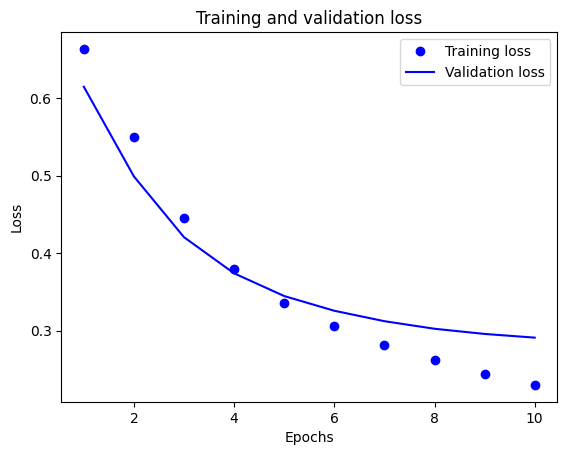

In [26]:
acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, "bo", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

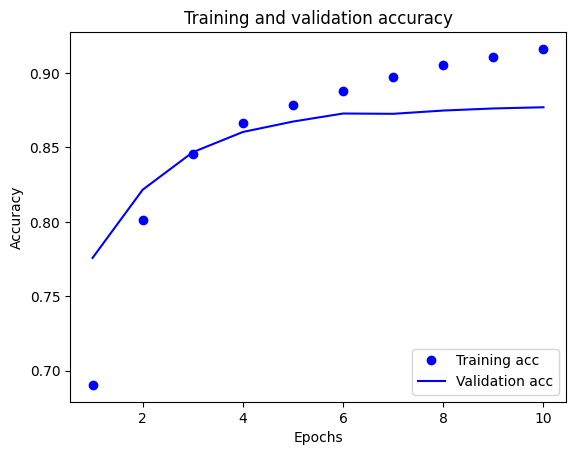

In [27]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.show()

In [28]:
export_model = tf.keras.Sequential(
    [vectorize_layer, model, layers.Activation("sigmoid")]
)

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"],
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 1s 1ms/step - loss: 0.3100 - accuracy: 0.8738
0.8738399744033813


In [30]:
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible...",
    "I have mixed feelings. On the one hand, I enjoyed the open ending, but on the other hand, the plot was just fine.",
]

export_model.predict(examples)

1/1 [==============================] - 0s 21ms/step


array([[0.6377554 ],
       [0.4630454 ],
       [0.3768099 ],
       [0.62593746]], dtype=float32)